<a href="https://colab.research.google.com/github/luludamermaid/machineLearning/blob/main/ltsm_stock_closingPrice4_swks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

upload stock price file from hard drive

This code is tested with SWKS stock price

In [2]:
#importing required libraries
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from google.colab import files
import io
import numpy as np
import pandas as pd



from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
#constants
#prior days data to predict stock price
PRIOR_DAYS = 70
#set to True if splitting train/test data by percentage. set to False if splitting train/test data by number of data. if set to false, set TEST_DATA_COUNT to how many item from the last to be in test data
TRAIN_DATA_SPLIT_BY_PERCENT = True 
# % training data, out of all data. The rest will be test data
TRAIN_DATA_SPLIT_PERCENT = 85 #was 79%
#how many data item from the last (latest date) to use as test (to predict)
TEST_DATA_COUNT =  1 
#LSTM layers
LSTM_LAYERS_UNITS=[60,60,60]
EPOCHS=5
BATCH_SIZE=1
LOSS='mean_squared_error'
OPTIMIZER='adam'
ADD_DROPOUT_LAYER=True
DROPOUT = 0.2 


In [4]:
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['SWKS.csv']))
#df = pd.read_csv("C:\\Lu\\AI\\experiments\\KNN\\data\\SWKS.csv")

Saving SWKS.csv to SWKS.csv


pre-process input data - reformat data into stock trading dates, and closing price 


In [5]:
df = df.dropna() #drop N/A data
#creating dataframe
data = df.sort_index(ascending=True, axis=0)

#make a dataframe with index of dates instead of 0,1,2,3 that we read from the file
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Open', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Open'][i] = data['Open'][i]
    new_data['Close'][i] = data['Close'][i]
#setting dates as index
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)

In [6]:
new_data.head()

,Open,Close
Date,,
2016-01-06,71.55,69.15
2016-01-07,66.6,67.16
2016-01-08,68.56,66.89
2016-01-11,67.18,66.05
2016-01-12,66.72,66.63


Create train and test datasets

In [7]:
#data is numpy array
#return value: x is time_steps days prior day closing price, and y is today closing price 
def create_model_data(data, data_start_index, data_length, time_steps):
  
  #arrange prior_days_close and y data. prior_days_close is time_step prior days closing price. y is today closing price.
  prior_days_close, today_close, today_open = [],[],[]
  
  start = data_start_index + time_steps
  end = data_start_index+data_length
 
  open_lookback=np.zeros(time_steps)
  

  for i in range(start,end):
  
    prior_days_close.append(data[i-time_steps:i,1]) #prior days close
   
    open_lookback[time_steps-1] = data[i,0] #today open
  
    today_open.append(np.array(open_lookback)) #use np.array(open_lookback) so append function argument is passed by value   
    today_close.append(data[i,1]) #today close

  prior_days_close = np.array(prior_days_close)
  today_open= np.array(today_open)
 

  prior_days_close=np.expand_dims(prior_days_close, axis = 2)
  today_open=np.expand_dims(today_open, axis = 2)
  x = np.concatenate((prior_days_close,today_open), axis=2)
  return (x,np.array(today_close))


In [8]:

dataset = new_data.values #numpy values of the dataframe. In this case we get numpy array of n rows (n=entries in stock data) and 1 column. 

#scale data
scaler=MinMaxScaler(feature_range=(0,1)) #scale data to 0-1 range
scaled_data=scaler.fit_transform(dataset) #scaled_data is numpy array

In [9]:
print(type(dataset))
print(dataset.shape)


<class 'numpy.ndarray'>
(1252, 2)


In [10]:
#get x and y training data
(x,y) = create_model_data(scaled_data, 0, len(scaled_data), PRIOR_DAYS)

#split data into training and testing.
if TRAIN_DATA_SPLIT_BY_PERCENT : 
  split = round((len(scaled_data) - PRIOR_DAYS)*TRAIN_DATA_SPLIT_PERCENT/100)
else:
  split = len(scaled_data) - PRIOR_DAYS - TEST_DATA_COUNT  

In [11]:
x_train = x[0:split,:,:]
y_train = y[0:split]
x_test = x[split:,:,:]
y_test= y[split:]


LSTM network expects the input to be in the form [samples, time steps, features] where samples is the number of data points we have, time steps is the number of time-dependent steps that are there in a single data point, number of input features. (From this site https://www.analyticsvidhya.com/blog/2017/12/fundamentals-of-deep-learning-introduction-to-lstm/)

Note that LSTM model takes 3D array as input. set return_sequences to true if you want to stack up LSTM layers. With return_sequence=true, the lstm will output 3D array (versus 1D) for the next LSTM layer. So if you plan on stacking the LSTM layers, make sure the prior LSTM layer has return_sequence = True

In [12]:
# create and fit the LSTM network
def create_lstm_model(x, units_list_by_layers,  return_seq=True ):
  model = Sequential()
  #there's no rule in selecting units. Some people would have it less than the time series count. Other than that, Good luck!!
  model.add(LSTM(units=units_list_by_layers[0], return_sequences=return_seq, input_shape=(x.shape[1],x.shape[2]))) 
  ltsm_layers = len(units_list_by_layers)
  for i in range (1, ltsm_layers):
    if ADD_DROPOUT_LAYER:
      model.add(Dropout(DROPOUT))
    model.add(LSTM(units=units_list_by_layers[i], return_sequences= (i< ltsm_layers-1)))

  model.add(Dense(1)) #I think dense layer here is for changing dimension of the vector to 1 dimension in this case. All the predicted closing price is just a list of prices thus 1 dimension
  
  return model

model = create_lstm_model(x_train, LSTM_LAYERS_UNITS)

model.compile(loss=LOSS, optimizer=OPTIMIZER)
model.fit(x_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=2)
  


Epoch 1/5
1005/1005 - 57s - loss: 0.0037
Epoch 2/5
1005/1005 - 37s - loss: 0.0016
Epoch 3/5
1005/1005 - 37s - loss: 0.0011
Epoch 4/5
1005/1005 - 36s - loss: 9.8643e-04
Epoch 5/5
1005/1005 - 36s - loss: 9.2578e-04


In [13]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 70, 60)            15120     
_________________________________________________________________
dropout (Dropout)            (None, 70, 60)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 70, 60)            29040     
_________________________________________________________________
dropout_1 (Dropout)          (None, 70, 60)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60)                29040     
_________________________________________________________________
dense (Dense)                (None, 1)                 61        
Total params: 73,261
Trainable params: 73,261
Non-trainable params: 0
____________________________________________________

In [14]:
print(x_test.shape)
x_train.shape
print(y_train.shape)
y_train[0:3]

(177, 70, 2)
(1005,)


array([0.18658633, 0.16179381, 0.16781903])

In [15]:
#predicting on test data
closing_price_raw = model.predict(x_test)



In [16]:
print('closing_price_raw shape')
print(closing_price_raw.shape)
print('closing_price_raw 0->1')
print(closing_price_raw[0:1])
print('closing_price_raw type')
print(type(closing_price_raw))
print('y_test type')
print(type(y_test))
print('y_test shape')
print(y_test.shape)

closing_price_raw shape
(177, 1)
closing_price_raw 0->1
[[0.37940413]]
closing_price_raw type
<class 'numpy.ndarray'>
y_test type
<class 'numpy.ndarray'>
y_test shape
(177,)


In [17]:
closing_price = np.zeros(shape=(closing_price_raw.shape[0],2))
closing_price[:,0] = closing_price_raw[:,0]
print("closing_price.shape")
print(closing_price.shape)
print("closing_price_raw.shape")
print(closing_price_raw.shape)
print("closing_price[0:5,0]")
print(closing_price[0:5,0])
print("closing_price_raw[0:5,0]")
print(closing_price_raw[0:5,0])

closing_price.shape
(177, 2)
closing_price_raw.shape
(177, 1)
closing_price[0:5,0]
[0.37940413 0.38074929 0.39831632 0.38677585 0.37146944]
closing_price_raw[0:5,0]
[0.37940413 0.3807493  0.39831632 0.38677585 0.37146944]


In [18]:
print(closing_price[0:5,1])

[0. 0. 0. 0. 0.]


In [19]:
closing_price = scaler.inverse_transform(closing_price)

In [20]:
print(closing_price[0:2,:])
print(closing_price.shape)

[[94.67781007 55.849998  ]
 [94.8145857  55.849998  ]]
(177, 2)


In [21]:
rms=np.sqrt(np.mean(np.power((dataset[split+PRIOR_DAYS:,0]-closing_price[:,0]),2)))
print("Root mean square error is %.2f"%rms)

Root mean square error is 8.72


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


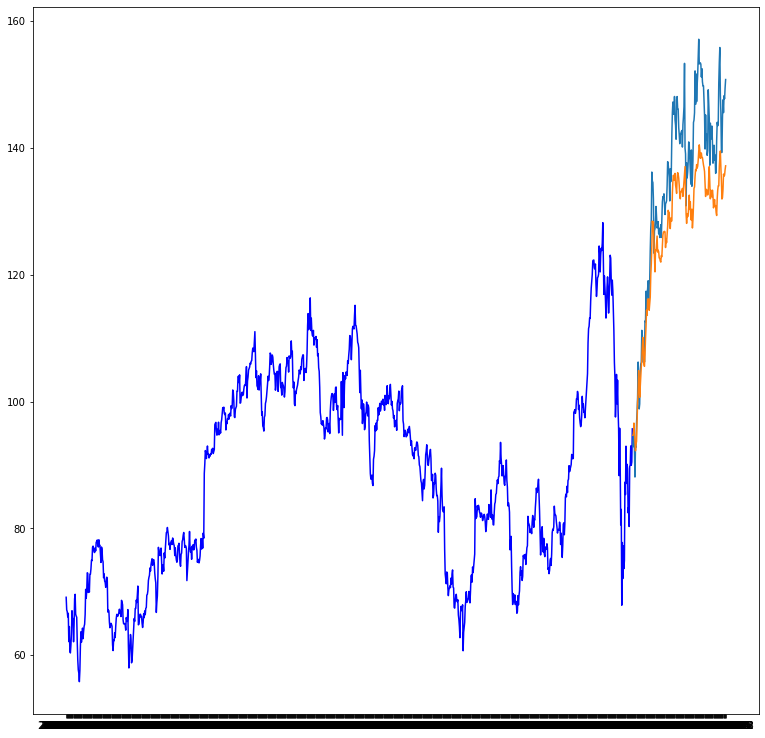

In [22]:
#for plotting
#to plot within notebook
import matplotlib.pyplot as plt
%matplotlib inline
train = new_data[0:split+PRIOR_DAYS]
test = new_data[split+PRIOR_DAYS:]
test['Predictions'] = closing_price[:,0]
plt.figure(figsize=(13,13))
plt.plot(train['Close'], color = "blue", label ="training data")
plt.plot(test[['Close','Predictions']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


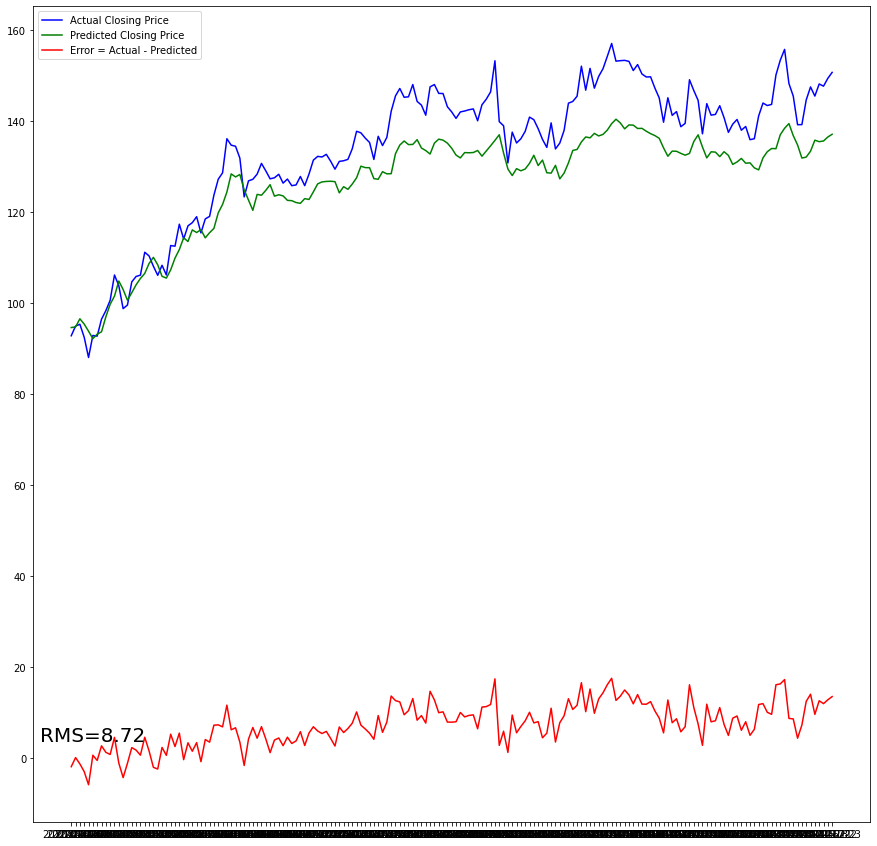

In [23]:
test['Error'] = test['Close'] - test['Predictions']
plt.figure(figsize=(15,15))
rms_str="RMS=%.2f"%rms
plt.text(5,5, rms_str, fontsize=20, horizontalalignment='center', verticalalignment='center')
plt.plot(test['Close'], color = "blue", label ="Actual Closing Price")
plt.plot(test['Predictions'], color = "green", label = "Predicted Closing Price")
plt.plot(test['Error'], color="red", label = "Error = Actual - Predicted")
plt.legend(loc = "upper left")
plt.show()

In [24]:
print(len(test.index))
#print(test.tail(10))
print(test[-10:]['Error'])

177
Date
2020-12-10    8.68932
2020-12-11    4.45174
2020-12-14    7.35072
2020-12-15    12.5443
2020-12-16    14.1161
2020-12-17    9.68945
2020-12-18    12.6794
2020-12-21    12.0447
2020-12-22    12.8923
2020-12-23       13.6
Name: Error, dtype: object


copy prediction result to csv file


In [25]:
from google.colab import files
test.to_csv("lstm_prediction_result.csv")
files.download("lstm_prediction_result.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Only Predict

In [26]:
'''def create_x_only(data, start_index, length, reshape_x_for_ltsm=True):
  end_index = start_index+length
  x=[]
  for i in range(start_index,end_index):
    x.append(data[i-PRIOR_DAYS+1:i+1,0])  #do :i+1 because it will only go up to i+1-1
  x = np.array(x)
  if reshape_x_for_ltsm:
    x = np.reshape(x, (x.shape[0],x.shape[1],1)) #reshape x into samples,time steps, features as required by lstm model 
  return x

x_latest = create_x_only(scaled_data, len(scaled_data)-1, 1 )
print(len(scaled_data))
print(x_latest.shape)
#print(x_latest)'''

'def create_x_only(data, start_index, length, reshape_x_for_ltsm=True):\n  end_index = start_index+length\n  x=[]\n  for i in range(start_index,end_index):\n    x.append(data[i-PRIOR_DAYS+1:i+1,0])  #do :i+1 because it will only go up to i+1-1\n  x = np.array(x)\n  if reshape_x_for_ltsm:\n    x = np.reshape(x, (x.shape[0],x.shape[1],1)) #reshape x into samples,time steps, features as required by lstm model \n  return x\n\nx_latest = create_x_only(scaled_data, len(scaled_data)-1, 1 )\nprint(len(scaled_data))\nprint(x_latest.shape)\n#print(x_latest)'

In [27]:
#y_latest_predicted = model.predict(x_latest)

In [28]:
#y_latest_predicted = scaler.inverse_transform(y_latest_predicted)
#print(y_latest_predicted)

In [29]:
'''from sklearn.preprocessing import MinMaxScaler
import numpy as np

a=np.array([[-1.2, -3.5, 9, 4.7, -0.01], [4.5,6.25,-9.7,5.6,-10.2]])
scaler2 = MinMaxScaler(feature_range = (-1,1))
scaled2 = scaler2.fit_transform(a)
print(scaled2)'''

'from sklearn.preprocessing import MinMaxScaler\nimport numpy as np\n\na=np.array([[-1.2, -3.5, 9, 4.7, -0.01], [4.5,6.25,-9.7,5.6,-10.2]])\nscaler2 = MinMaxScaler(feature_range = (-1,1))\nscaled2 = scaler2.fit_transform(a)\nprint(scaled2)'